# Backtest: validation on historical data

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna-ts/master?filepath=examples/backtest.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebook contains the simple examples of time series validation using backtest module of ETNA library.

**Table of Contents**

* [What is backtest and how it works](#chapter1)  
* [How to run a validation](#chapter2)
* [Validation visualisation](#chapter3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MSE
from etna.metrics import SMAPE
from etna.metrics.base import MetricAggregationMode
from etna.model_selection.backtest import CrossValidationMode
from etna.model_selection.backtest import TimeSeriesCrossValidation
from etna.models.base import Model
from etna.models.prophet import ProphetModel
from etna.transforms.base import Transform
from etna.analysis.plotters import plot_backtest

### 1. What is backtest and how it works <a class="anchor" id="chapter1"></a>

Backtest is a predictions and validation pipeline build on historical data to make a legitimate retrotest of your model.

<b>How does it work?</b>

When constructing a forecast using Models and further evaluating the prediction metrics, we measure the quality at one time interval, designated as test.

Backtest allows you to simulate how the model would work in the past:

* selects a period of time in the past

* builds a model using the selected interval as a training sample

* predicts the value on the test interval and calculates metrics.

The image shows a plot of the backtest pipeline with `n_folds = 3`.

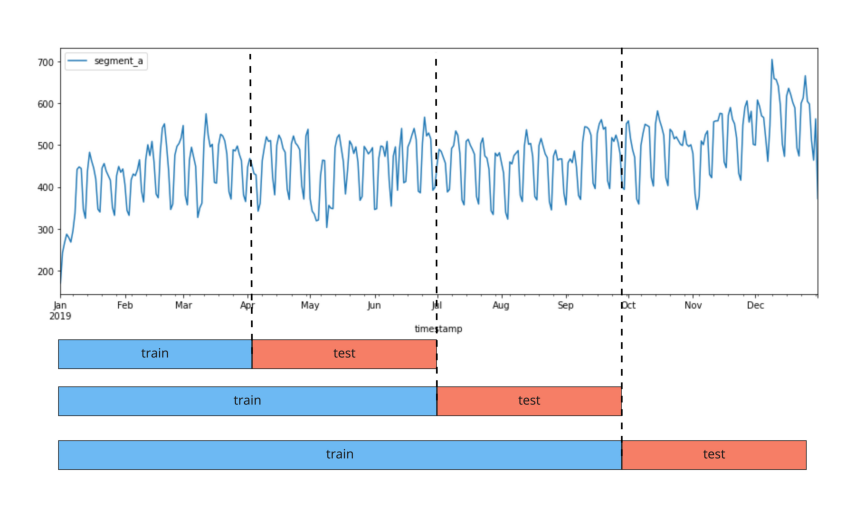

In [2]:
img = plt.imread("./assets/backtest/backtest.jpg")
plt.figure(figsize=(15, 10))
plt.axis('off')
_ = plt.imshow(img)

Below we will call a fold the train + test pair, for which training and forecasting is performed.

In [3]:
df = pd.read_csv("./data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.loc[df.segment == 'segment_a']
df.head()

timestamp    segment  target
0 2019-01-01  segment_a     170
1 2019-01-02  segment_a     243
2 2019-01-03  segment_a     267
3 2019-01-04  segment_a     287
4 2019-01-05  segment_a     279

Our library works with the spacial data structure TSDataset. So, before starting the EDA, we need to convert the classical DataFrame to TSDataset.

In [4]:
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq='D')

#### Let's get a look on series

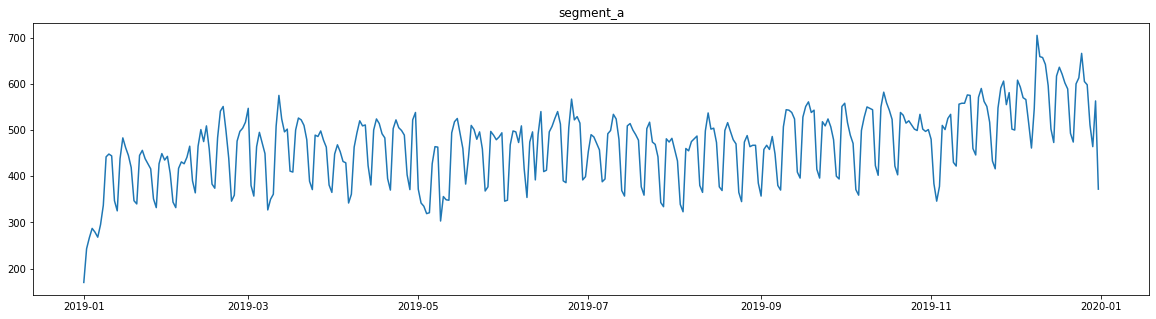

In [5]:
ts.plot(segments=['segment_a'])

### 2. How to run a validation <a class="anchor" id="chapter2"></a>

For an easy start let's create a Prophet model

In [6]:
horizon = 31 # Set the horizon for predictions
model = ProphetModel() # Create a model
transforms = [] #A list of transforms -  we will not use any of them

Now let's create and run TimeSeriesCrossValidation

In [7]:
tscv = TimeSeriesCrossValidation(model=model, horizon=horizon, metrics=[MAE(), MSE(), SMAPE()])

As a result of TimeSeriesCrossValidation.backtest, three dataframes are returned: a dataframe with metrics for each fold and each segment, a dataframe with predictions, a dataframe with information about folds

In [8]:
metrics_df, forecast_df, fold_info_df = tscv.backtest(ts=ts, transforms=transforms)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.23333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       424.324    0.00270715       109.442   2.893e-05       0.001      182  LS failed, Hessian reset 
      99       424.474    0.00386819       92.9422           1           1      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165        424.59   2.73334e-06       88.3246   3.791e-08       0.001      319  LS failed, Hessian reset 
     189        424.59   9.02359e-09       70.9445       0.203       0.203      353   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.9227
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       498.205   9.97651e-05       89.9933           1           1      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116        498.22   0.000190286       104.026   2.297e-06       0.001      207  LS failed, Hessian reset 
     199       498.236   3.60289e-08       60.1791           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       498.358    0.00125428       85.4195   1.223e-05       0.001      423  LS failed, Hessian reset 
     299       498.435    0.00031373       103.899           1           1      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       498.438   3.56359e-05       92.4805   3.902e-07       0.001      540  LS failed, Hessian rese

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -15.657
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       568.354   0.000396664       67.8495      0.2016      0.2016      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       568.589    0.00123099       78.9198   2.262e-05       0.001      252  LS failed, Hessian reset 
     199       569.138   9.00104e-05       67.1809      0.5077      0.5077      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       569.309   8.14658e-05       75.3132   1.005e-06       0.001      524  LS failed, Hessian reset 
     299       569.313    3.3851e-06       77.9762      0.5766      0.5766      541   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       569.314   1.68362e-08       69.6839      0.3873           1      578   
Optimization terminate

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -12.3458
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        639.71   2.18197e-05       73.9563           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156        639.88    0.00150705       82.2678   1.923e-05       0.001      250  LS failed, Hessian reset 
     199       639.985   1.58572e-05       68.6412      0.2369           1      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       640.764   8.25362e-05       77.0914   1.023e-06       0.001      421  LS failed, Hessian reset 
     294       640.769   9.66722e-06        90.317   1.272e-07       0.001      501  LS failed, Hessian reset 
     299        640.77   2.86877e-06       72.5105      0.6198      0.6198      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -12.6574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        717.87    0.00016435       83.6047           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       719.058    0.00118663       80.0895   1.622e-05       0.001      274  LS failed, Hessian reset 
     199       719.115   1.16395e-05       82.1581           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.116   3.83712e-08       51.6196      0.9112      0.9112      367   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.5s finished


In [9]:
metrics_df.head()

segment        MAE          MSE      SMAPE  fold_number
0  segment_a  21.026386   673.218627   4.842741            0
0  segment_a  30.681333  1364.176883   6.430815            1
0  segment_a  35.994811  1999.778938   7.426069            2
0  segment_a  31.221071  1830.978276   6.325664            3
0  segment_a  55.867831  4959.431980  10.174486            4

In [10]:
forecast_df.head()

segment      segment_a            
feature         target fold_number
timestamp                         
2019-07-30  506.605023           0
2019-07-31  495.446783           0
2019-08-01  486.187796           0
2019-08-02  473.629848           0
2019-08-03  390.171221           0

In [11]:
fold_info_df.head()

train_start_time train_end_time test_start_time test_end_time  fold_number
0       2019-01-01     2019-07-29      2019-07-30    2019-08-29            0
0       2019-01-01     2019-08-29      2019-08-30    2019-09-29            1
0       2019-01-01     2019-09-29      2019-09-30    2019-10-30            2
0       2019-01-01     2019-10-30      2019-10-31    2019-11-30            3
0       2019-01-01     2019-11-30      2019-12-01    2019-12-31            4

You can additionally get the metrics averaged over folds:

In [12]:
tscv.get_metrics(aggregate_metrics=True)

segment        MAE          MSE     SMAPE
0  segment_a  34.958286  2165.516941  7.039955

### 3. Validation visualisation <a class="anchor" id="chapter3"></a>

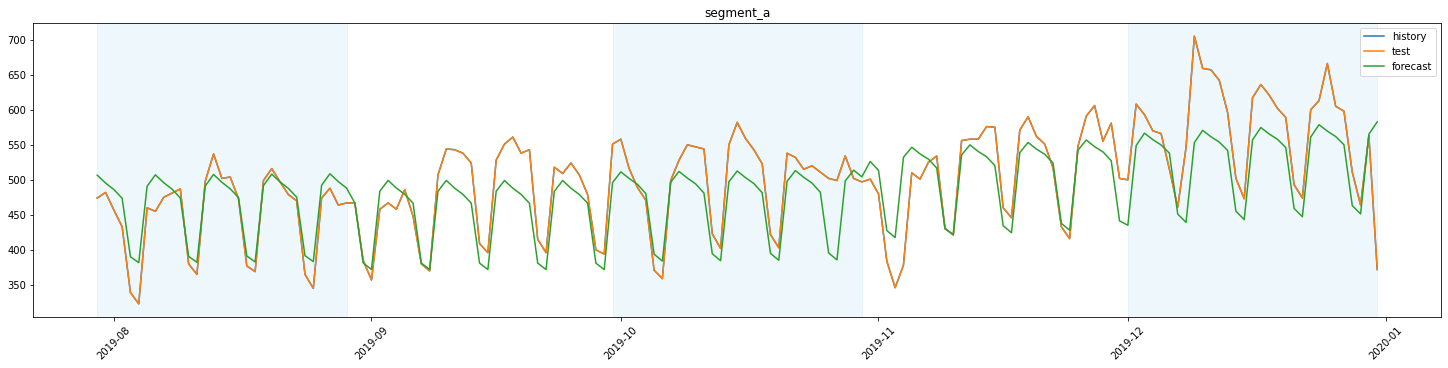

In [13]:
plot_backtest(forecast_df, ts)

Let's see how the data looked before the backtest -  we specify `history_len`.

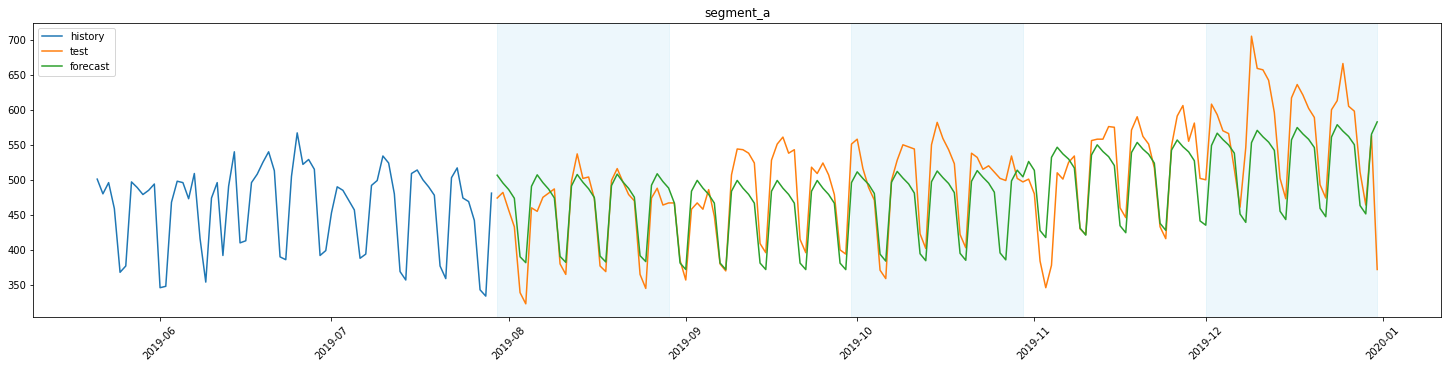

In [14]:
plot_backtest(forecast_df, ts, history_len=70)

That's all for this notebook. More features you can find in our documentation!